In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import kstest
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay




red_wines = pd.read_csv("winequality-red.csv", sep = ";")
white_wines = pd.read_csv("winequality-white.csv", sep =";")


# Mental note (procedure)
* convert type of wine into numbers 
* run heatmap to see correlation between components and type of wine
1) run the machine learning model to determine type of wine as it is (copy paste)
2) check results
2) perform feautre scaling! 
3) run machine model removing features with low correlation to type of wine
3) check feature by feature for outliers
4) perform hypothesis tests to see if the the difference in chemical composition is significant in each case.
5) remove columns from insignificant features. 
4) run machine learning model again with the new results
5) split data with validation 

# Formatting

In [2]:
# formatting
red_wines.columns= red_wines.columns.str.replace(' ','_')
white_wines.columns = white_wines.columns.str.replace(' ','_')

#Quality categories
red_wines ['quality_label'] = red_wines['quality'].apply(lambda value: 'low' if value <= 5 
                                                        else 'medium' if value <= 7 
                                                        else 'high')

red_wines['quality_label'] = pd.Categorical(red_wines['quality_label'],
categories=['low', 'medium', 'high'])

white_wines ['quality_label'] = white_wines['quality'].apply(lambda value: 'low' if value <= 5 
                                                        else 'medium' if value <= 7 
                                                        else 'high')

white_wines["quality_label"] = pd.Categorical(white_wines["quality_label"], categories = ["low","medium","high"])

# Type of wine categories
red_wines ["type"] = 'Red Wine'
red_wines['type'] = pd.Categorical(red_wines['type'],
categories=["Red Wine","White Wine"])

white_wines ["type"] = 'White Wine'
white_wines['type'] = pd.Categorical(white_wines['type'],
categories=["Red Wine","White Wine"])

# merge datasets
white_and_red = pd.merge(red_wines, white_wines, how = "outer")

#make copy
white_and_red_ml= white_and_red.copy()

In [3]:
red_wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed_acidity         1599 non-null   float64 
 1   volatile_acidity      1599 non-null   float64 
 2   citric_acid           1599 non-null   float64 
 3   residual_sugar        1599 non-null   float64 
 4   chlorides             1599 non-null   float64 
 5   free_sulfur_dioxide   1599 non-null   float64 
 6   total_sulfur_dioxide  1599 non-null   float64 
 7   density               1599 non-null   float64 
 8   pH                    1599 non-null   float64 
 9   sulphates             1599 non-null   float64 
 10  alcohol               1599 non-null   float64 
 11  quality               1599 non-null   int64   
 12  quality_label         1599 non-null   category
 13  type                  1599 non-null   category
dtypes: category(2), float64(11), int64(1)
memory usage: 153.

In [4]:
white_and_red_ml.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_label,type
0,3.8,0.310,0.02,11.1,0.036,20.0,114.0,0.99248,3.75,0.44,12.4,6,medium,White Wine
1,3.9,0.225,0.40,4.2,0.030,29.0,118.0,0.98900,3.57,0.36,12.8,8,high,White Wine
2,4.2,0.170,0.36,1.8,0.029,93.0,161.0,0.98999,3.65,0.89,12.0,7,medium,White Wine
3,4.2,0.215,0.23,5.1,0.041,64.0,157.0,0.99688,3.42,0.44,8.0,3,low,White Wine
4,4.4,0.320,0.39,4.3,0.030,31.0,127.0,0.98904,3.46,0.36,12.8,8,high,White Wine


# Hypothesis testing 
Purpose : Compare the distributions of chemical components (x) of two independent groups (red and white wine) to determine if their central tendencies (medians) are different.
Null Hypothesis: The distributions of x levels in red and white wines are the same.
Alternative Hypothesis: The distributions (or medians) of x levels in red and white wines are different.

Using Mann Whitney U test because data is not normally distributed and am comparing two independent groups

In [5]:
from scipy.stats import mannwhitneyu
red_wines_sulph = red_wines["sulphates"]
white_wines_sulph = white_wines["sulphates"]
stat, p = mannwhitneyu(red_wines["sulphates"], white_wines["sulphates"], alternative='two-sided')

print(f"P-value: {p}")
if p < 0.05:
    print(f"sulphates levels in red and white wine are significantly different")
else:
    print(f"There is no significant difference in sulphate levels")

P-value: 0.0
sulphates levels in red and white wine are significantly different


## function to apply hypothesis test to all the data set

In [6]:
from scipy.stats import mannwhitneyu

def compare_columns_with_mannwhitneyu(red_wines, white_wines, alternative='two-sided'):
   
    # Get common numeric columns between the two DataFrames
    common_columns = list(set(red_wines.select_dtypes(include=['float64', 'int64']).columns)
                          & set(white_wines.select_dtypes(include=['float64', 'int64']).columns))
    
    # Iterate through the columns
    for column in common_columns:
        # Perform the Mann-Whitney U test
        stat, p = mannwhitneyu(red_wines[column], white_wines[column], alternative="two-sided")
        
        # Output the results
        if p < 0.05:
            print(f"{column} levels in red and white wine are significantly different (p = {p})")
        else:
            print(f"There is no significant difference in {column} levels (p = {p})")

# Run the comparison
compare_columns_with_mannwhitneyu(red_wines, white_wines)



pH levels in red and white wine are significantly different (p = 5.47225819092577e-162)
volatile_acidity levels in red and white wine are significantly different (p = 0.0)
There is no significant difference in alcohol levels (p = 0.18184514400050011)
quality levels in red and white wine are significantly different (p = 3.6343410707988e-23)
citric_acid levels in red and white wine are significantly different (p = 1.3125581817242063e-38)
residual_sugar levels in red and white wine are significantly different (p = 5.6340728348736734e-95)
free_sulfur_dioxide levels in red and white wine are significantly different (p = 0.0)
total_sulfur_dioxide levels in red and white wine are significantly different (p = 0.0)
chlorides levels in red and white wine are significantly different (p = 0.0)
density levels in red and white wine are significantly different (p = 1.4530913918780195e-237)
fixed_acidity levels in red and white wine are significantly different (p = 1.4389300228621962e-255)
sulphates l

In [7]:
common_columns = list(set(red_wines.select_dtypes(include=['float64', 'int64']).columns)
                          & set(white_wines.select_dtypes(include=['float64', 'int64']).columns))



# Encoding

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
white_and_red_ml['type'] = le.fit_transform(white_and_red_ml['type'])

white_and_red_ml["type"].head()
white_and_red_ml["type"].tail()

white_and_red_ml.head()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_label,type
0,3.8,0.310,0.02,11.1,0.036,20.0,114.0,0.99248,3.75,0.44,12.4,6,medium,1
1,3.9,0.225,0.40,4.2,0.030,29.0,118.0,0.98900,3.57,0.36,12.8,8,high,1
2,4.2,0.170,0.36,1.8,0.029,93.0,161.0,0.98999,3.65,0.89,12.0,7,medium,1
3,4.2,0.215,0.23,5.1,0.041,64.0,157.0,0.99688,3.42,0.44,8.0,3,low,1
4,4.4,0.320,0.39,4.3,0.030,31.0,127.0,0.98904,3.46,0.36,12.8,8,high,1


# Heatmap for type of wine

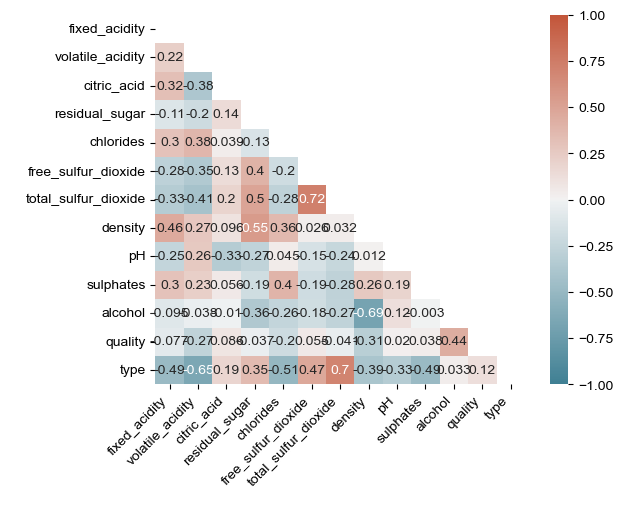

In [9]:
white_and_red_drop = white_and_red_ml.drop("quality_label", axis = 1)
corr = white_and_red_drop.corr()
matrix = np.triu(corr)
heatmap_wines = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=256),
    square=True,
    annot = True,
    mask =  matrix
)
heatmap_wines.set_xticklabels(
    heatmap_wines.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
sns.set_theme(rc = {'figure.figsize':(15,8)})
plt.show()

# Split data


In [10]:
from sklearn.model_selection import train_test_split
X=white_and_red_ml.drop(["type","quality_label","quality"], axis=1)
y= white_and_red_ml["type"]

print("original:", white_and_red_ml.shape, "\nX:", X.shape, "\ny:", y.shape)


original: (6497, 14) 
X: (6497, 11) 
y: (6497,)


In [11]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#\n is a escape character that will create a new line when used

In [12]:
X

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,3.8,0.310,0.02,11.1,0.036,20.0,114.0,0.99248,3.75,0.44,12.4
1,3.9,0.225,0.40,4.2,0.030,29.0,118.0,0.98900,3.57,0.36,12.8
2,4.2,0.170,0.36,1.8,0.029,93.0,161.0,0.98999,3.65,0.89,12.0
3,4.2,0.215,0.23,5.1,0.041,64.0,157.0,0.99688,3.42,0.44,8.0
4,4.4,0.320,0.39,4.3,0.030,31.0,127.0,0.98904,3.46,0.36,12.8
...,...,...,...,...,...,...,...,...,...,...,...
6492,15.5,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1
6493,15.5,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1
6494,15.6,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1
6495,15.6,0.685,0.76,3.7,0.100,6.0,43.0,1.00320,2.95,0.68,11.2


# Standarization and normalization

In [13]:
#REVIEW - do this after trying the first round
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing data
X_test_norm = norm.transform(X_test)



#  normalization methods

In [14]:
for x in white_wines.select_dtypes(include="float64").columns:
    print(x,": ", shapiro(white_wines[x]))

fixed_acidity :  ShapiroResult(statistic=np.float64(0.9765614632981108), pvalue=np.float64(1.1501523036992453e-27))
volatile_acidity :  ShapiroResult(statistic=np.float64(0.9045496512191041), pvalue=np.float64(4.5867977211289734e-48))
citric_acid :  ShapiroResult(statistic=np.float64(0.9222472643649706), pvalue=np.float64(1.0131795882390018e-44))
residual_sugar :  ShapiroResult(statistic=np.float64(0.8845685866424623), pvalue=np.float64(2.820711554872405e-51))
chlorides :  ShapiroResult(statistic=np.float64(0.5908083764919935), pvalue=np.float64(2.140584304591907e-75))
free_sulfur_dioxide :  ShapiroResult(statistic=np.float64(0.9420691373918115), pvalue=np.float64(3.857850118366439e-40))
total_sulfur_dioxide :  ShapiroResult(statistic=np.float64(0.9890146202553135), pvalue=np.float64(4.383458182915739e-19))
density :  ShapiroResult(statistic=np.float64(0.954804847330493), pvalue=np.float64(1.780897972116447e-36))
pH :  ShapiroResult(statistic=np.float64(0.9880964981563648), pvalue=np.f

Since all the p-value are less than .05, we reject the null hypothesis of the Shapiro-Wilk test. This means we have sufficient evidence to say that the samples data do not come from a normal distribution.

# Outliers


## Function to clean outliers with z score

### white wine

In [15]:

# create a copy of the columns(numeric values only) to iterate over ( if not it iterates over the newly created as well)
white_wines_clean= white_wines.drop("quality", axis=1)
numeric_columns = white_wines_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()
z_score_dict = {}
for x in numeric_columns:
    z_score_dict[f'z_score_{x}'] = zscore(white_wines[x])


# Create a DataFrame from the z_score_dict
z_score_df = pd.DataFrame(z_score_dict, index=white_wines.index)

# Concatenate the original DataFrame with the z_score DataFrame

white_wines_with_zscores = pd.concat([white_wines_clean, z_score_df], axis=1)

# # Filter rows where the absolute value of all z_scores is less than 3
z_score_columns = z_score_df.columns
filtered_white_wines = white_wines_with_zscores[(white_wines_with_zscores[z_score_columns].abs() < 3).all(axis=1)]
filtered_white_wines


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,...,z_score_volatile_acidity,z_score_citric_acid,z_score_residual_sugar,z_score_chlorides,z_score_free_sulfur_dioxide,z_score_total_sulfur_dioxide,z_score_density,z_score_pH,z_score_sulphates,z_score_alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,...,-0.081770,0.213280,2.821349,-0.035355,0.569932,0.744565,2.331512,-1.246921,-0.349184,-1.393152
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,...,0.215896,0.048001,-0.944765,0.147747,-1.253019,-0.149685,-0.009154,0.740029,0.001342,-0.824276
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,...,0.017452,0.543838,0.100282,0.193523,-0.312141,-0.973336,0.358665,0.475102,-0.436816,-0.336667
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,...,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,...,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,...,-0.677101,-0.365197,-0.944765,-0.310008,-0.664970,-1.091000,-0.965483,0.541334,0.088973,0.557282
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,...,0.414339,0.213280,0.317179,0.056196,1.275590,0.697499,0.291789,-0.253446,-0.261553,-0.743008
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,...,-0.379435,-1.191592,-1.023637,-0.218457,-0.312141,-0.643875,-0.497350,-1.313153,-0.261553,-0.905544
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,...,0.116674,-0.282557,-1.043355,-1.088192,-0.900190,-0.667408,-1.784717,1.004955,-0.962605,1.857572


In [16]:
white_wines.shape

(4898, 14)

### Red wine

In [17]:
red_wines_clean= red_wines.drop("quality", axis=1)
numeric_columns_red = red_wines_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()
z_score_dict_red = {}
for x in numeric_columns_red:
    z_score_dict_red[f'z_score_{x}'] = zscore(red_wines[x])


# Create a DataFrame from the z_score_dict
z_score_df_red = pd.DataFrame(z_score_dict_red, index=red_wines.index)

# Concatenate the original DataFrame with the z_score DataFrame

red_wines_with_zscores = pd.concat([red_wines_clean, z_score_df_red], axis=1)

# # Filter rows where the absolute value of all z_scores is less than 3
z_score_columns_red = z_score_df_red.columns
filtered_red_wines = red_wines_with_zscores[(red_wines_with_zscores[z_score_columns_red].abs() < 3).all(axis=1)]
filtered_red_wines

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,...,z_score_volatile_acidity,z_score_citric_acid,z_score_residual_sugar,z_score_chlorides,z_score_free_sulfur_dioxide,z_score_total_sulfur_dioxide,z_score_density,z_score_pH,z_score_sulphates,z_score_alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,...,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,...,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,...,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,...,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,...,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,...,0.403229,-0.980669,-0.382271,0.053845,1.542054,-0.075043,-0.978765,0.899886,-0.461180,0.072294
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,...,0.123905,-0.877968,-0.240375,-0.541259,2.211469,0.137820,-0.862162,1.353436,0.601055,0.729364
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,...,-0.099554,-0.723916,-0.169427,-0.243707,1.255161,-0.196679,-0.533554,0.705508,0.542042,0.541630
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,...,0.654620,-0.775267,-0.382271,-0.264960,1.542054,-0.075043,-0.676657,1.677400,0.305990,-0.209308


In [18]:
red_wines.shape

(1599, 14)

141 rows dropped

## FILTERING WITH IQR

### white wine

In [19]:
# Compute the first and third quantiles and IQR 
q1 = np.quantile(white_wines["citric_acid"], 0.25)
q3 = np.quantile(red_wines["citric_acid"], 0.75)
iqr = q3 - q1

# Calculate the lower and upper cutoffs for outliers
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

filtered_white_wines_iqr = white_wines[(white_wines["citric_acid"] > lower) & (white_wines["citric_acid"] < upper)]

In [20]:
# Loop iqr for all the df
white_wines_numeric = white_wines_clean.select_dtypes(include=['float64', 'int64'])
filtered_ww_df = white_wines.copy()
for column in white_wines_numeric.columns:
        q1 = np.quantile(white_wines_numeric[column], 0.25)
        q3 = np.quantile(white_wines_numeric[column], 0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        # Filter rows based on the column's outlier range
        filtered_ww_df = filtered_ww_df[(filtered_ww_df[column] >= lower) & (filtered_ww_df[column] <= upper)]
print("white wine shape; ", white_wines.shape, "\nfiltered white wine shape: ", filtered_ww_df.shape)

white wine shape;  (4898, 14) 
filtered white wine shape:  (4015, 14)


In [21]:
white_wines_numeric.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

### red wine

In [22]:
red_wines_numeric = red_wines_clean.select_dtypes(include=['float64', 'int64'])
filtered_rw_df = red_wines.copy()
for column in red_wines_numeric.columns:
        q1 = np.quantile(red_wines_numeric[column], 0.25)
        q3 = np.quantile(red_wines_numeric[column], 0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        # Filter rows based on the column's outlier range
        filtered_rw_df = filtered_rw_df[(filtered_rw_df[column] >= lower) & (filtered_rw_df[column] <= upper)]
print("red wine shape; ", red_wines.shape, "\nfiltered red wine shape: ", filtered_rw_df.shape)



red wine shape;  (1599, 14) 
filtered red wine shape:  (1194, 14)


# Checking skewness before and after filtering outliers

In [23]:
# Skewness before filter
white_wines_numeric = white_wines_clean.select_dtypes(include=['float64', 'int64'])
white_wines_skew_before = white_wines_numeric[white_wines_numeric.columns].skew()

#Skewness after filter
filtered_ww_numeric = filtered_ww_df.select_dtypes(include="float64")
filtered_ww_numeric[filtered_ww_numeric.columns].skew()
white_wines_skew_after= filtered_ww_numeric[filtered_ww_numeric.columns].skew()

skew_df= pd.concat([white_wines_skew_before, white_wines_skew_after], axis=1)
skew_df= skew_df.rename(columns={0:"before_filter", 1:"after_filter"})
skew_df["%"]= (skew_df["after_filter"]-skew_df["before_filter"])*100/skew_df["before_filter"]
skew_df

,before_filter,after_filter,%
fixed_acidity,0.647751,0.166461,-74.301769
volatile_acidity,1.576980,0.422422,-73.213195
citric_acid,1.281920,0.437999,-65.832604
residual_sugar,1.077094,0.736900,-31.584428
chlorides,5.023331,0.076283,-98.481431
free_sulfur_dioxide,1.406745,0.291204,-79.299475
total_sulfur_dioxide,0.390710,0.308793,-20.966064
density,0.977773,0.300642,-69.252414
pH,0.457783,0.196842,-57.001010
sulphates,0.977194,0.467672,-52.141347


<Axes: >

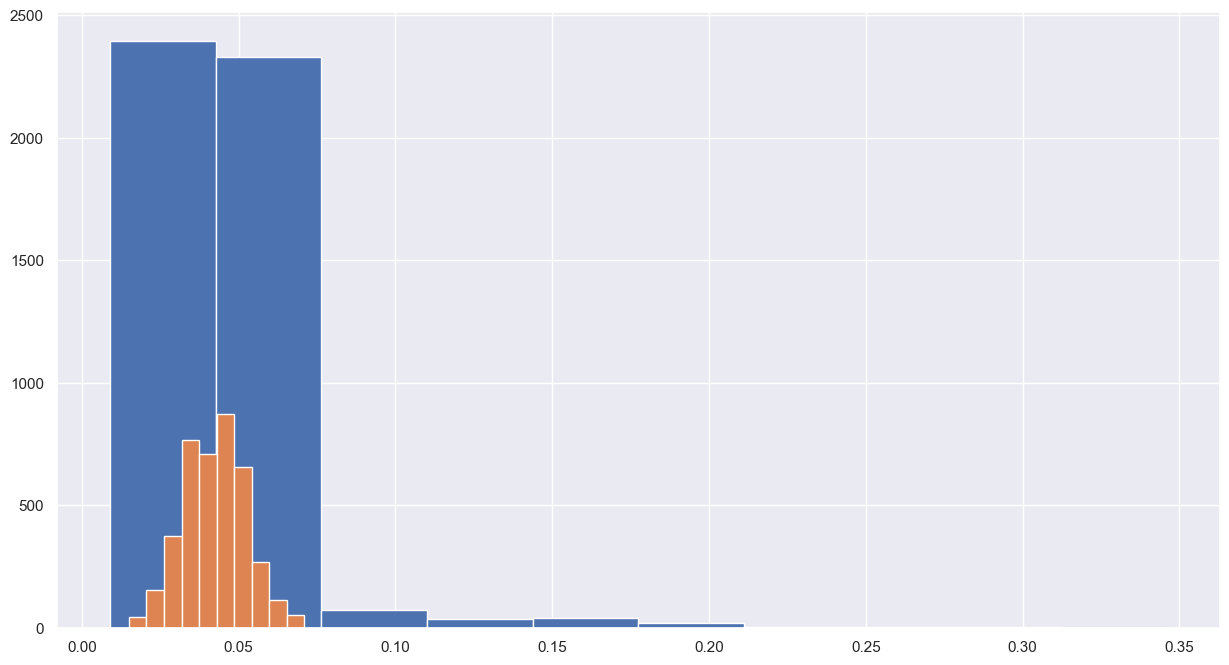

In [24]:
white_wines["chlorides"].hist()
filtered_ww_df["chlorides"].hist()

# Logistic Regression


## Model 1
(without filters)

In [25]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression(max_iter=700)

In [26]:
LR_model.fit(X_train_norm, y_train)

LogisticRegression(max_iter=700)

In [27]:
preds = LR_model.predict(X_test_norm)
print(preds)

[1 1 1 ... 1 1 1]


### Accuracy

In [28]:
from sklearn.metrics import accuracy_score 

acc = accuracy_score(y_test, preds)
acc

0.9892307692307692

## filter red wines

## ML 2 - LR
without alcohol

### drop

In [29]:
white_and_red_ml2= white_and_red.copy()
white_and_red_ml2 = white_and_red_ml2.drop("alcohol", axis=1)


### encoding

In [30]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
white_and_red_ml2['type'] = le.fit_transform(white_and_red_ml2['type'])

white_and_red_ml2["type"].head()
white_and_red_ml2["type"].tail()

6492    0
6493    0
6494    0
6495    0
6496    0
Name: type, dtype: int64

In [31]:
from sklearn.model_selection import train_test_split
X2=white_and_red_ml2.drop(["type","quality_label","quality"], axis=1)
y2= white_and_red_ml2["type"]

print("original:", white_and_red_ml2.shape, "\nX:", X2.shape, "\ny:", y2.shape)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=42)

original: (6497, 13) 
X: (6497, 10) 
y: (6497,)


### standarization

In [32]:
norm = MinMaxScaler().fit(X2_train)

# transform training data
X2_train_norm = norm.transform(X2_train)

# transform testing data
X2_test_norm = norm.transform(X2_test)

### logistic regression

In [53]:
LR_model2 = LogisticRegression(max_iter=700)
LR_model2.fit(X2_train_norm, y2_train)
preds2 = LR_model2.predict(X2_test_norm)
print(preds2)

[1 1 1 ... 1 1 1]


### Accuracy

In [34]:
acc2 = accuracy_score(y2_test, preds2)
acc2

0.9884615384615385

### Result 
Less accurate than model 1

In [35]:
print(f"Model 2 accuracy score: {acc2}")

Model 2 accuracy score: 0.9884615384615385


## Ml 3
without citric acid

In [36]:
## drop
white_and_red_ml3= white_and_red.copy()
white_and_red_ml3 = white_and_red_ml3.drop("citric_acid", axis=1)

## encoding
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
white_and_red_ml3['type'] = le.fit_transform(white_and_red_ml3['type'])

white_and_red_ml3["type"].head()
white_and_red_ml3["type"].tail()
from sklearn.model_selection import train_test_split
X3=white_and_red_ml3.drop(["type","quality_label","quality"], axis=1)
y3= white_and_red_ml3["type"]

print("original:", white_and_red_ml3.shape, "\nX:", X3.shape, "\ny:", y3.shape)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.20, random_state=42)
## standarization
norm = MinMaxScaler().fit(X3_train)

# transform training data
X3_train_norm = norm.transform(X3_train)

# transform testing data
X3_test_norm = norm.transform(X3_test)
## logistic regression
LR_model3 = LogisticRegression(max_iter=700)
LR_model3.fit(X3_train_norm, y3_train)
preds3 = LR_model3.predict(X3_test_norm)
print(preds3)
## Accuracy
acc3 = accuracy_score(y3_test, preds3)

print(acc3)
# ## Result 
# Less accurate than model 1
# # Ml 3
# without citric acid

original: (6497, 13) 
X: (6497, 10) 
y: (6497,)
[1 1 1 ... 1 1 1]
0.9876923076923076


### Result

Less accurate than model 1 and 2

In [37]:
print(f"Model 3 accuracy score: {acc3}")

Model 3 accuracy score: 0.9876923076923076


## Ml3bis 
without alcohol and citric acid
Ignored after the results of 2 and 3

## Ml 4
with filtered out outliers

In [38]:
# drop the z_score columns, so I can use the the filtered df to do a new ML
filtered_white_wines_drop=filtered_white_wines.drop(z_score_columns, axis=1)
filtered_red_wines_drop = filtered_red_wines.drop(z_score_columns_red, axis=1)

# merge datasets
white_and_red_filtered = pd.merge(filtered_red_wines_drop, filtered_white_wines_drop, how = "outer")

## copy
white_and_red_ml4= white_and_red_filtered.copy()

## encoding

le = LabelEncoder()
white_and_red_ml4['type'] = le.fit_transform(white_and_red_ml4['type'])

# Split
X4=white_and_red_ml4.drop(["type","quality_label"], axis=1)
y4= white_and_red_ml4["type"]

print("original:", white_and_red_ml4.shape, "\nX:", X4.shape, "\ny:", y4.shape)

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.20, random_state=42)

# standarization
norm = MinMaxScaler().fit(X4_train)

# transform training data
X4_train_norm = norm.transform(X4_train)

# transform testing data
X4_test_norm = norm.transform(X4_test)

## logistic regression
LR_model4 = LogisticRegression(max_iter=700)
LR_model4.fit(X4_train_norm, y4_train)
preds4 = LR_model4.predict(X4_test_norm)

## Accuracy
acc4 = accuracy_score(y4_test, preds4)



original: (5960, 13) 
X: (5960, 11) 
y: (5960,)


### result

In [39]:
print(f"Model 4 accuracy score: {acc4}")

Model 4 accuracy score: 0.99748322147651


## Ml 5
filtered outliers with iqr


In [40]:
# merge datasets
white_and_red_iqr_filtered = pd.merge(filtered_rw_df, filtered_ww_df, how = "outer")

## copy
white_and_red_ml5= white_and_red_iqr_filtered.copy()

## encoding

le = LabelEncoder()
white_and_red_ml5['type'] = le.fit_transform(white_and_red_ml5['type'])

# Split
X5=white_and_red_ml5.drop(["type","quality_label"], axis=1)
y5= white_and_red_ml5["type"]

print("original:", white_and_red_ml5.shape, "\nX:", X5.shape, "\ny:", y5.shape)

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.20, random_state=42)

# standarization
norm = MinMaxScaler().fit(X5_train)

# transform training data
X5_train_norm = norm.transform(X5_train)

# transform testing data
X5_test_norm = norm.transform(X5_test)

## logistic regression
LR_model5 = LogisticRegression(max_iter=700)
LR_model5.fit(X5_train_norm, y5_train)
preds5 = LR_model5.predict(X5_test_norm)

## Accuracy
acc5 = accuracy_score(y5_test, preds5)




original: (5209, 14) 
X: (5209, 12) 
y: (5209,)


### result

In [41]:
print(f"Model 5 accuracy score: {acc5}")

Model 5 accuracy score: 0.9980806142034548


# Random Forest

## as it is

In [42]:
# define model
RF_clf = RandomForestClassifier(random_state=42)
# fit model
RF_clf.fit(X_train, y_train)
# make predictions
RF_preds = RF_clf.predict(X_test)

RF_acc = accuracy_score(y_test, RF_preds)
print( "Random Forest: ", RF_acc)

Random Forest:  0.9984615384615385


## with filtered values

In [43]:
# define model
RF_clf2 = RandomForestClassifier(random_state=42)
# fit model
RF_clf2.fit(X5_train, y5_train)
# make predictions
RF_preds2 = RF_clf2.predict(X5_test)

RF_acc2 = accuracy_score(y5_test, RF_preds2)
print( "Random Forest: ", RF_acc2)

Random Forest:  0.9990403071017274


# Evaluation Metrics

In [44]:
#Confusion matrix for linear regression model 1
cm = confusion_matrix(y_test, preds)

cm

array([[292,   8],
       [  6, 994]])

- True Positive&emsp;|  `1  1`   
- False Positive&nbsp;&ensp;|  `1  0`   
- True Negative&ensp;|  `0  0`  
- False Negative&nbsp;|  `0  1`  


In [45]:
cm_df = pd.DataFrame(cm,
  index = ["Red","White"],
  columns = ["Red","White"]
)
cm_df

,Red,White
Red,292,8
White,6,994


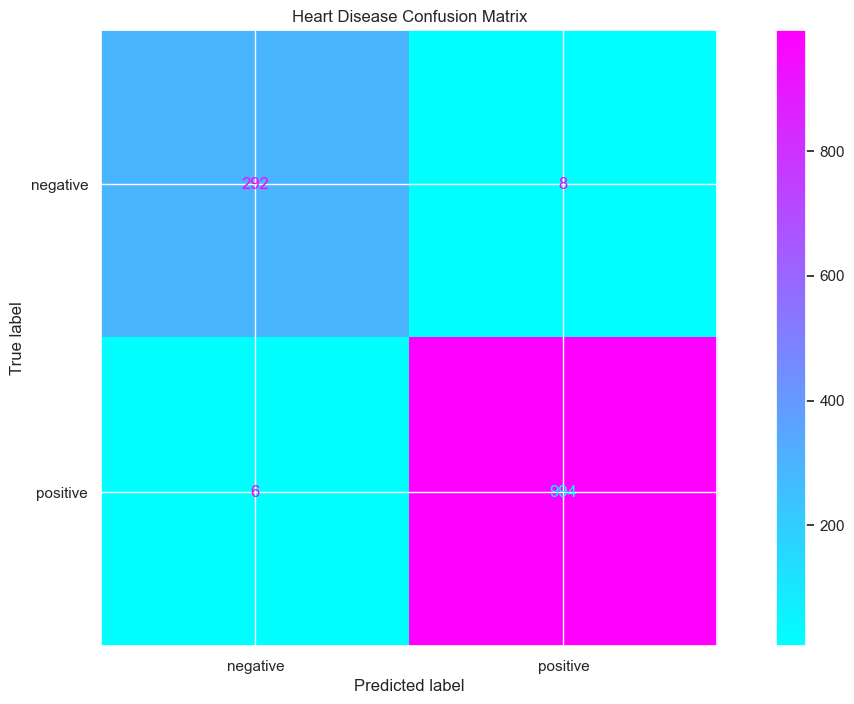

In [46]:
disp = ConfusionMatrixDisplay(cm, display_labels=["negative", "positive"])
disp.plot(cmap="cool")
plt.title('Heart Disease Confusion Matrix')
plt.show()

## confusion matrix

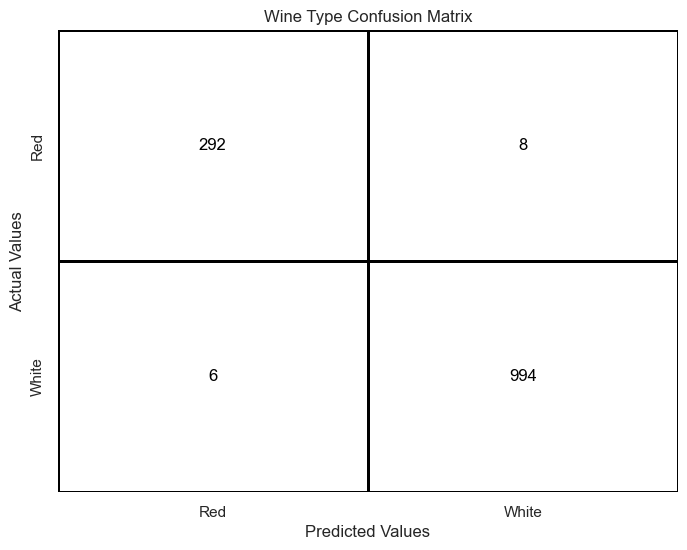

In [47]:
plt.figure(figsize=(8,6))

# Create a custom color map where all values are white
cmap = sns.color_palette(["#FFFFFF"])

sns.heatmap(cm_df, annot=True, fmt=".3g",cmap=cmap, cbar=False, linewidths=.8, linecolor='black', annot_kws={"color": "black"})
plt.title('Wine Type Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Classification Reports

## Linear regression

In [48]:
from sklearn.metrics import classification_report
# print(classification_report(y_test, LR_preds))

report = classification_report(y_test, preds)
print("model 1", "\n",report)
report2 = classification_report(y2_test, preds2)
print("model 2", "\n",report2)



model 1 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       300
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      1300
   macro avg       0.99      0.98      0.98      1300
weighted avg       0.99      0.99      0.99      1300

model 2 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       300
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      1300
   macro avg       0.99      0.98      0.98      1300
weighted avg       0.99      0.99      0.99      1300



In [49]:
report3 = classification_report(y3_test, preds3)
print("model 3", "\n",report3)
report4 = classification_report(y4_test, preds4)
print("model 4", "\n",report4)
report5 = classification_report(y5_test, preds5)
print("model 6", "\n",report5)

model 3 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       300
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      1300
   macro avg       0.98      0.98      0.98      1300
weighted avg       0.99      0.99      0.99      1300

model 4 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       297
           1       1.00      1.00      1.00       895

    accuracy                           1.00      1192
   macro avg       1.00      1.00      1.00      1192
weighted avg       1.00      1.00      1.00      1192

model 6 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00       802

    accuracy                           1.00      1042
   macro avg       1.00      1.00      1.00      1042
weighted avg       1.00      1.00      1.00 

## random forest

In [50]:
report6 = classification_report(y5_test, RF_preds2)
print("model 6", "\n",report6)

model 6 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00       802

    accuracy                           1.00      1042
   macro avg       1.00      1.00      1.00      1042
weighted avg       1.00      1.00      1.00      1042



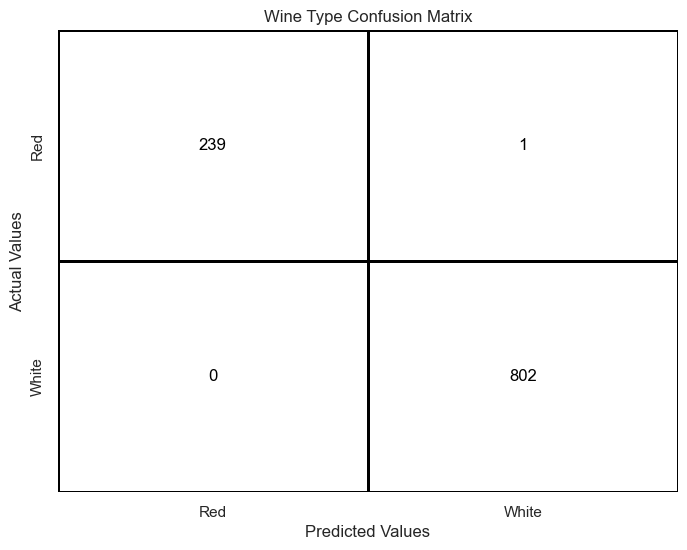

In [51]:
cm_rf = confusion_matrix(y5_test, RF_preds2)
cm_rf_df = pd.DataFrame(cm_rf,
  index = ["Red","White"],
  columns = ["Red","White"]
)
plt.figure(figsize=(8,6))

# Create a custom color map where all values are white
cmap = sns.color_palette(["#FFFFFF"])

sns.heatmap(cm_rf_df, annot=True, fmt=".3g",cmap=cmap, cbar=False, linewidths=.8, linecolor='black', annot_kws={"color": "black"})
plt.title('Wine Type Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

